In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# MNE Libraries
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs

# Scipy libraries
from scipy import signal
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

In [2]:
# Define the plot output path
plot_output_path = Path('plot_outputs')

# Create directory if it doesn't exist
plot_output_path.mkdir(exist_ok=True)
print(f"Directory '{plot_output_path}' is ready.")

Directory 'plot_outputs' is ready.


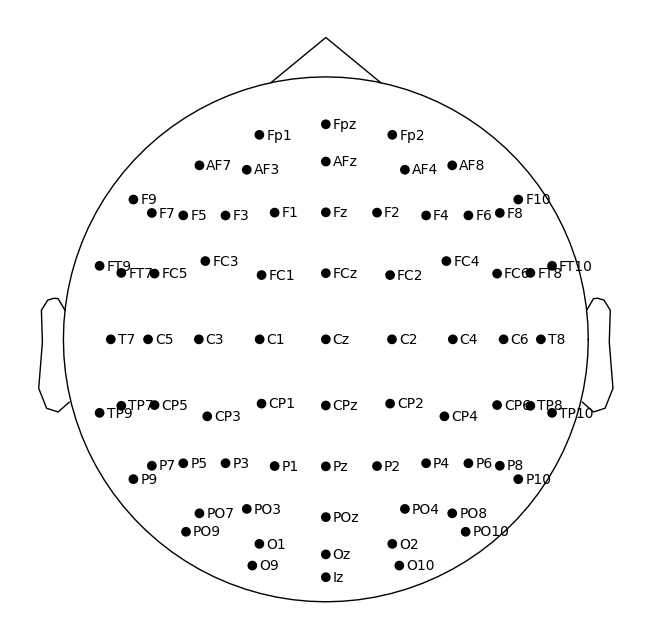

In [3]:
# Set montage
standard_1020_montage = mne.channels.make_standard_montage('easycap-M1')
standard_1020_montage.plot()
plt.show()

# Load Subject Information

In [5]:
# Subject Information
subject_info = pd.read_csv('data/seina_scalp/subject_info.csv')

In [6]:
# Define the data directory
data_dir = Path('data')

# Initialize lists to store data
all_seizures = []
all_patients = []

# Load all JSON files from subdirectories
json_files = sorted(list(data_dir.glob('**/*.json')))  # ** searches subdirectories, sorted for consistent order
print(f"Found {len(json_files)} JSON files")
print("Files found:")
for f in json_files:
    print(f"  - {f}")
print("\nLoading data...")

for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Extract patient-level information
        patient_info = {
            'patient_id': data['patient_id'],
            'sampling_rate_hz': data['sampling_rate_hz'],
            'num_channels': len(data['channels']),
            'json_file_path': str(json_file)  # Store the file path for reference
        }
        
        # Check if there's a top-level file_name (like PN01)
        if 'file_name' in data:
            patient_info['file_name'] = data['file_name']
            patient_info['registration_start_time'] = data.get('registration_start_time')
            patient_info['registration_end_time'] = data.get('registration_end_time')
        
        # Store patient info
        all_patients.append(patient_info)
        
        # Process each seizure
        for seizure in data['seizures']:
            seizure_record = {
                'patient_id': data['patient_id'],
                'sampling_rate_hz': data['sampling_rate_hz'],
                'seizure_number': seizure['seizure_number']
            }
            
            # Add all seizure fields dynamically to handle variations
            for key, value in seizure.items():
                seizure_record[key] = value
            
            # If file info is at patient level, add it to seizure record
            if 'file_name' in patient_info and 'file_name' not in seizure:
                seizure_record['file_name'] = patient_info['file_name']
                if 'registration_start_time' in patient_info:
                    seizure_record['registration_start_time'] = patient_info['registration_start_time']
                    seizure_record['registration_end_time'] = patient_info['registration_end_time']
            
            all_seizures.append(seizure_record)
            
    except Exception as e:
        print(f"Error loading {json_file}: {e}")
        continue

print("\nData loading complete!")

# Create DataFrames
seizures_df = pd.DataFrame(all_seizures)
patients_df = pd.DataFrame(all_patients)

Found 15 JSON files
Files found:
  - data\chb-mit\chb01\Seizures-list-CHB01.json
  - data\seina_scalp\PN00\Seizures-list-PN00.json
  - data\seina_scalp\PN01\Seizures-list-PN01.json
  - data\seina_scalp\PN03\Seizures-list-PN03.json
  - data\seina_scalp\PN05\Seizures-list-PN05.json
  - data\seina_scalp\PN06\Seizures-list-PN06.json
  - data\seina_scalp\PN07\Seizures-list-PN07.json
  - data\seina_scalp\PN09\Seizures-list-PN09.json
  - data\seina_scalp\PN10\Seizures-list-PN10.json
  - data\seina_scalp\PN11\Seizures-list-PN11.json
  - data\seina_scalp\PN12\Seizures-list-PN12.json
  - data\seina_scalp\PN13\Seizures-list-PN13.json
  - data\seina_scalp\PN14\Seizures-list-PN14.json
  - data\seina_scalp\PN16\Seizures-list-PN16.json
  - data\seina_scalp\PN17\Seizures-list-PN17.json

Loading data...

Data loading complete!


# Data Loading and Raw EDF Plotting


Processing subject PN00...
Found 5 EDF file(s)
  Processing PN00-1.edf...
    Successfully loaded 35 channels
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 s)

Using matplotlib as 2D backend.
    Saved raw plot to plot_outputs\PN00_raw_1_edf_plot.png
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting amplitude spectral density (dB=True).
    Saved PSD plot to plot_outputs\PN00_raw_1_psd_plot.png
    Saved averaged PSD plot to plot_outputs\PN00_raw_1_psd_averaged.

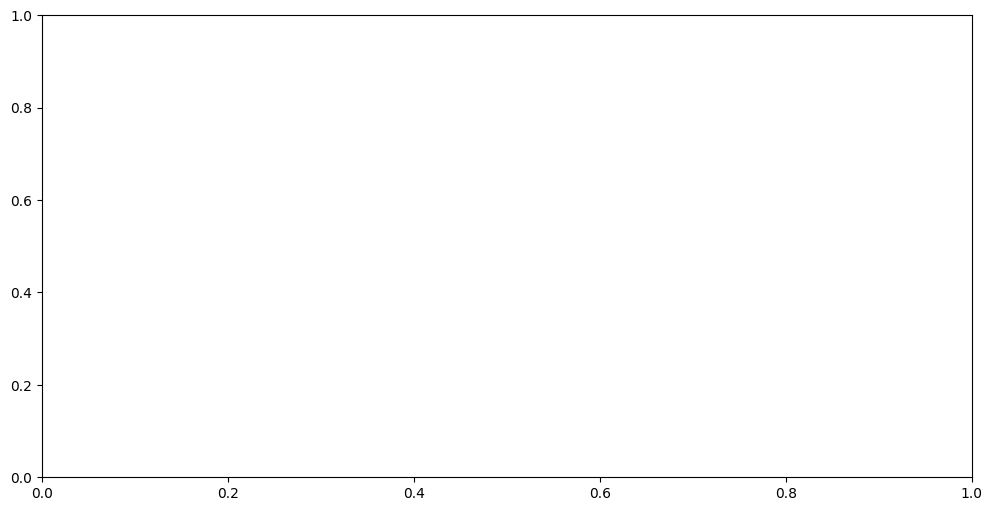

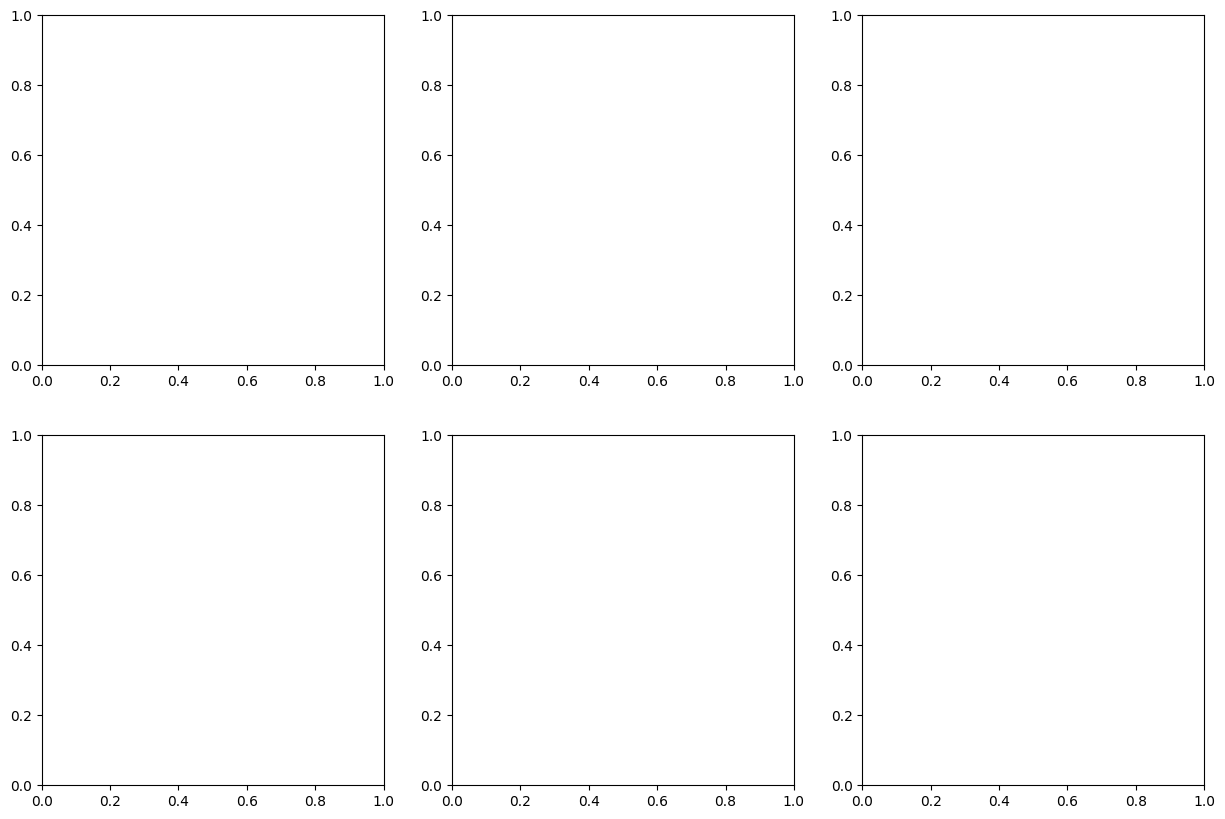

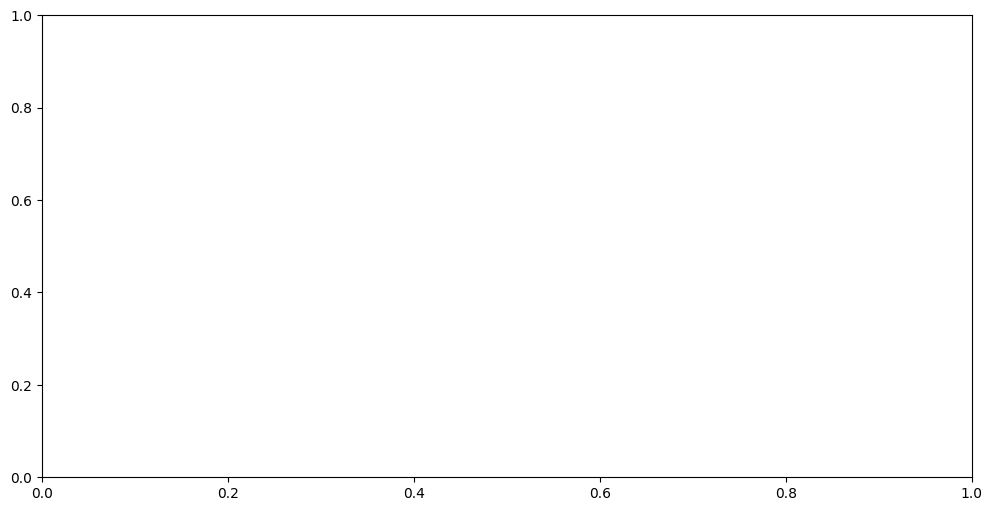

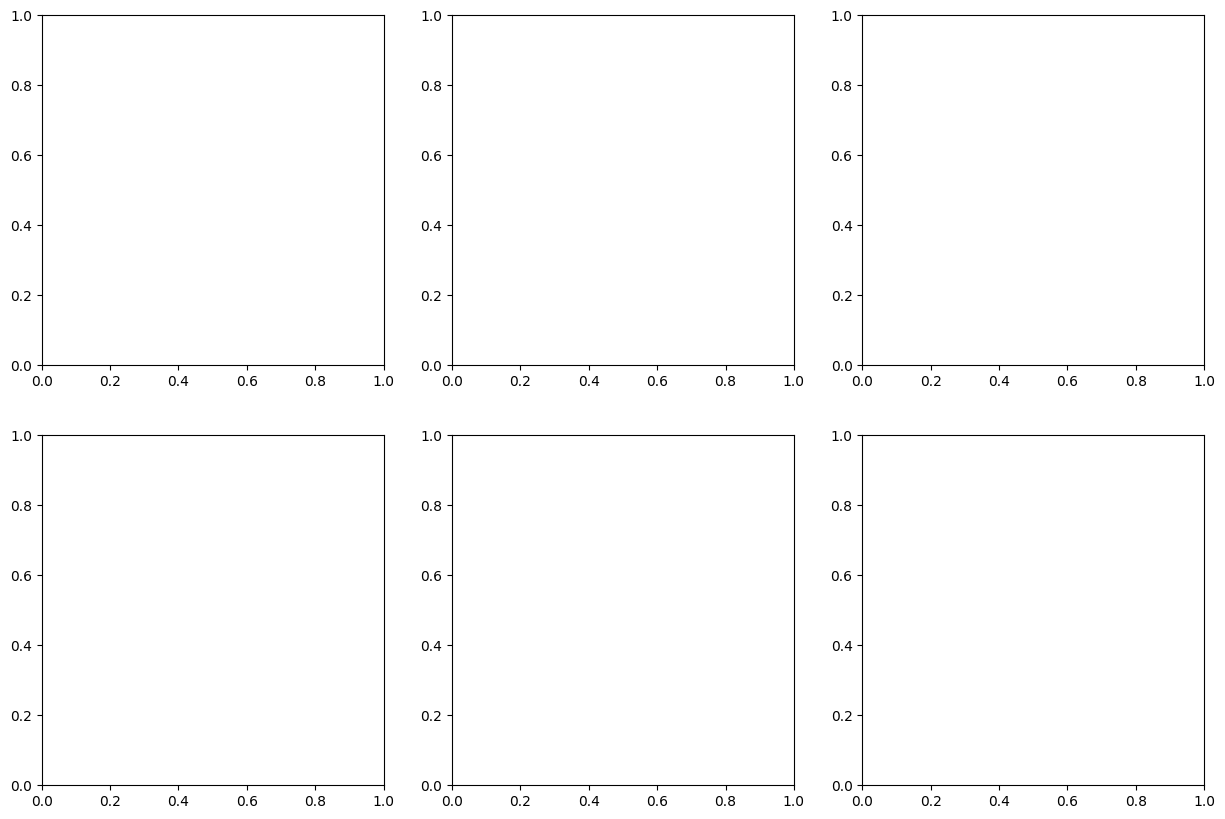

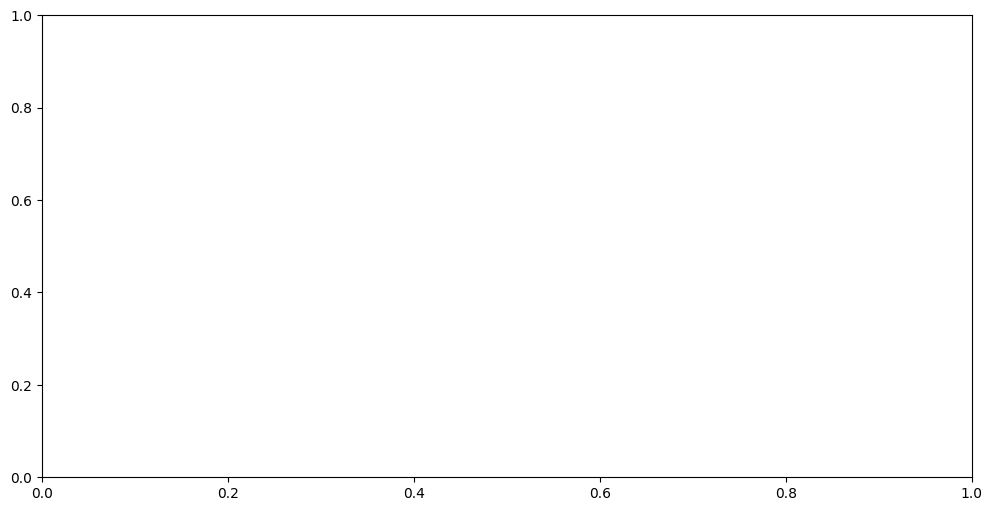

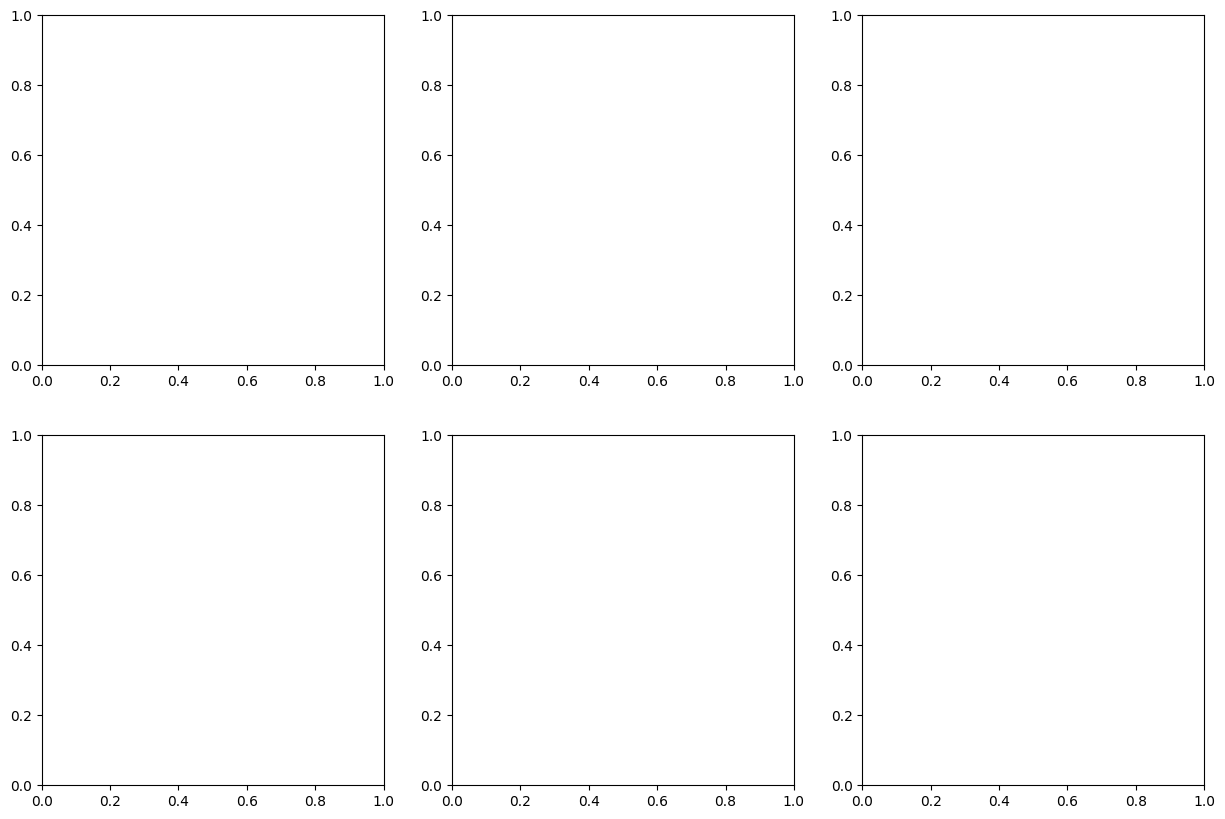

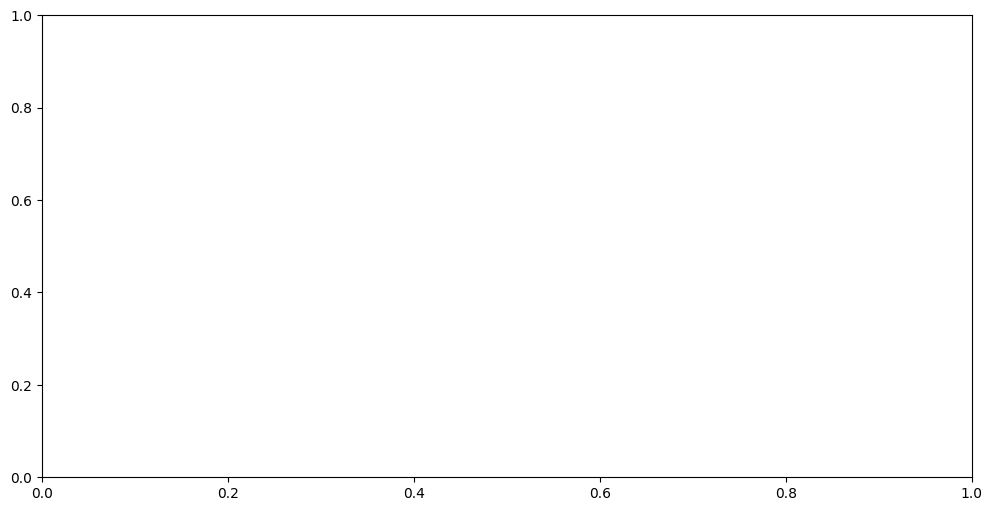

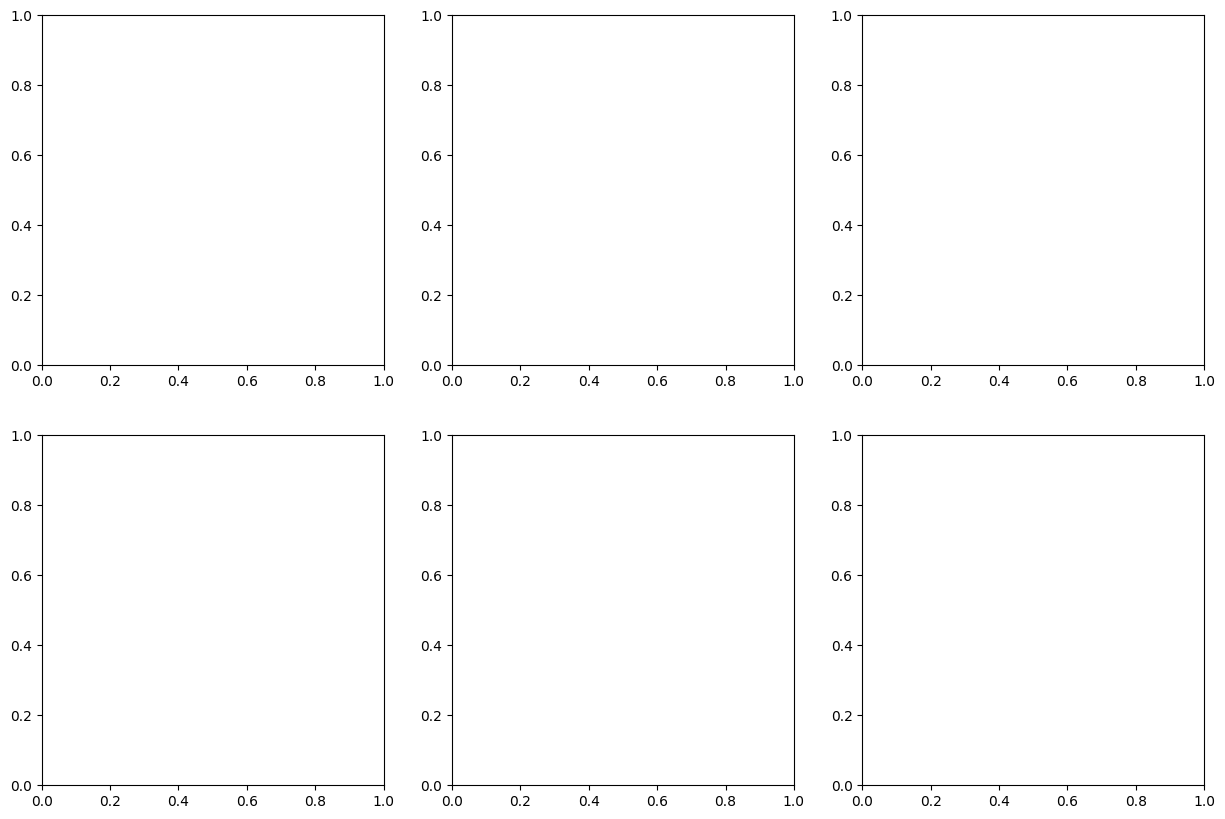

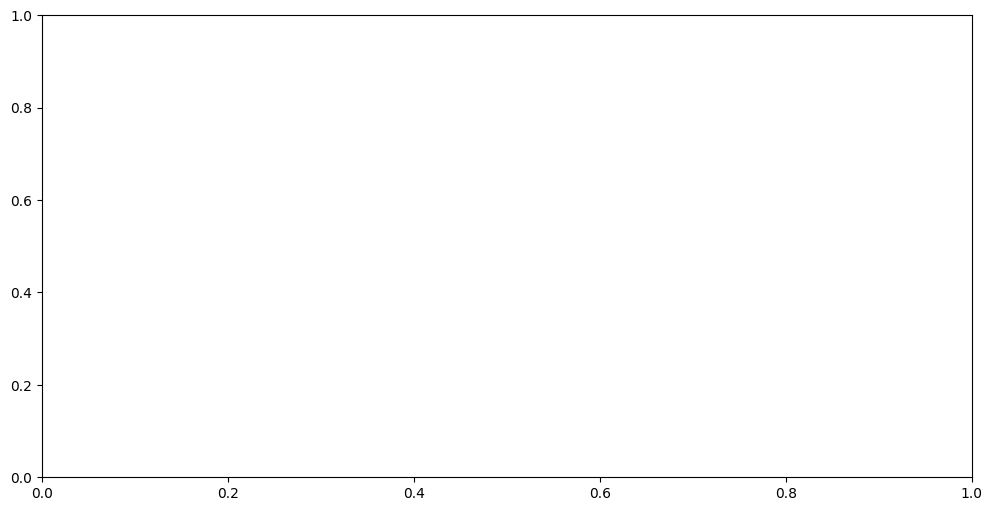

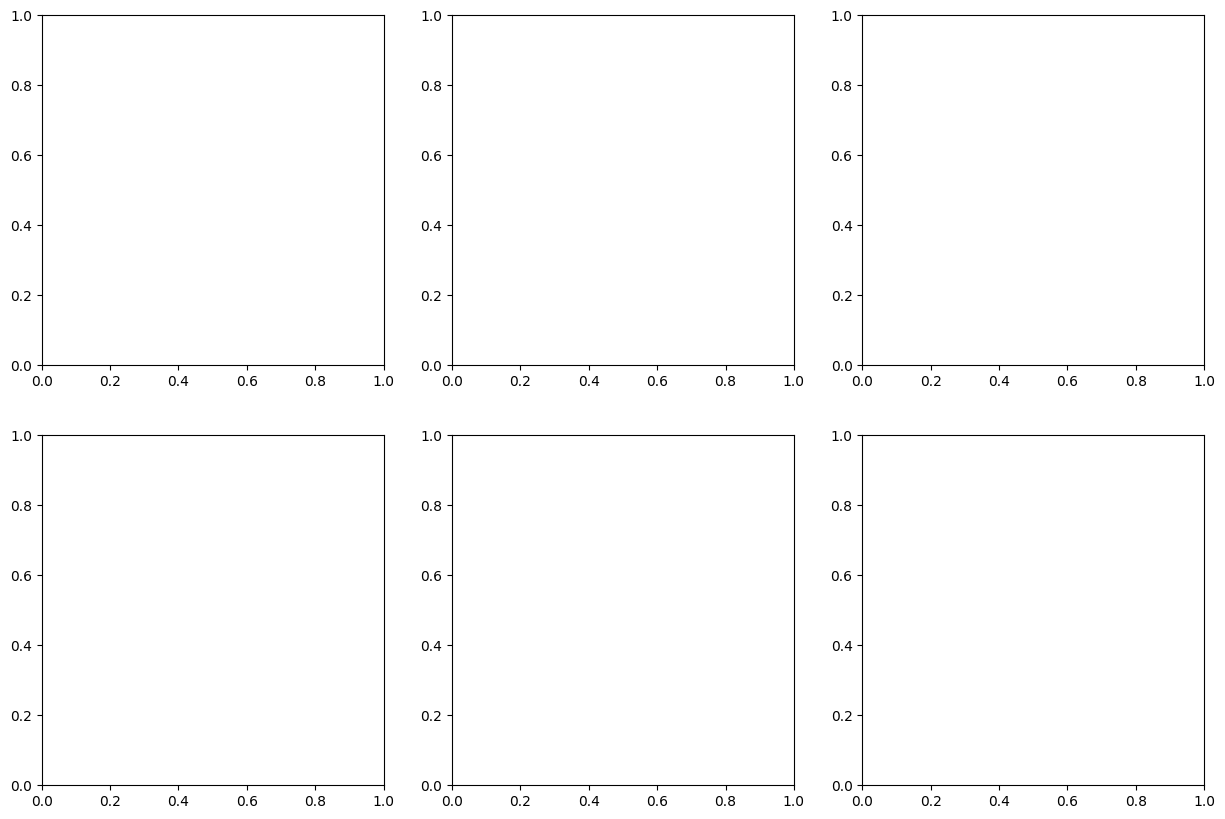

In [7]:
# Process Seina Scalp edf files
def process_all_edf_files(data_dir='data/seina_scalp', output_dir='plot_outputs'):
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Process subjects PN00 through PN17
    for subject_num in range(18):  # 0 to 17
        subject = f'PN{subject_num:02d}'  # Format as PN00, PN01, etc.
        subject_dir = Path(data_dir) / subject
        
        # Check if subject directory exists
        if not subject_dir.exists():
            print(f"Directory {subject_dir} not found, skipping...")
            continue
        
        # Find all .edf files in the subject directory
        edf_files = list(subject_dir.glob('*.edf'))
        
        if not edf_files:
            print(f"No EDF files found in {subject_dir}, skipping...")
            continue
        
        print(f"\nProcessing subject {subject}...")
        print(f"Found {len(edf_files)} EDF file(s)")
        
        # Process each EDF file
        for edf_file in edf_files:
            try:
                # Extract file number from filename (e.g., PN00-1.edf -> 1)
                file_stem = edf_file.stem  # Gets filename without extension
                file_num = file_stem.split('-')[-1] if '-' in file_stem else '1'
                
                print(f"  Processing {edf_file.name}...")
                
                # Load EDF file
                raw = mne.io.read_raw_edf(str(edf_file), preload=True, verbose=False)
                
                # Get available channels
                available_channels = raw.ch_names
                
                # Set channel types
                raw.set_channel_types({'2':'ecg', '1':'ecg'})
                
                print(f"    Successfully loaded {len(available_channels)} channels")
                
                # Apply bandpass filter between 0.5 and 30 Hz
                raw.filter(0.5, 30, fir_design='firwin')
                
                # Plot the raw time series data
                fig = raw.plot(show=False)  # Set show=False to prevent display
                output_filename = output_path / f'{subject}_raw_{file_num}_edf_plot.png'
                fig.savefig(output_filename)
                plt.close(fig)
                print(f"    Saved raw plot to {output_filename}")
                
                # Plot Power Spectral Density (PSD)
                try:
                    fig_psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30).plot(
                        average=False,  # Show individual channels
                        amplitude=True,  # Show in dB
                        spatial_colors=True,  # Color by sensor location
                        show=False
                    )
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_plot.png'
                    fig_psd.savefig(psd_filename)
                    plt.close(fig_psd)
                    print(f"    Saved PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                
                try:
                    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
                    # Compute PSD
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    
                    # Get data and average across channels
                    psds, freqs = psd.get_data(return_freqs=True)
                    psd_mean = np.mean(psds, axis=0)
                    psd_std = np.std(psds, axis=0)
                    
                    # Plot mean with std as shaded area
                    ax.plot(freqs, 10 * np.log10(psd_mean), 'b-', linewidth=2, label='Mean PSD')
                    ax.fill_between(freqs, 
                                10 * np.log10(psd_mean - psd_std), 
                                10 * np.log10(psd_mean + psd_std), 
                                alpha=0.3, label='±1 SD')
                    
                    # Add frequency band annotations
                    ax.axvspan(8, 12, alpha=0.2, color='green', label='Alpha (8-12 Hz)')
                    ax.axvspan(13, 30, alpha=0.2, color='orange', label='Beta (13-30 Hz)')
                    ax.axvspan(4, 7, alpha=0.2, color='blue', label='Theta (4-7 Hz)')
                    
                    ax.set_xlabel('Frequency (Hz)')
                    ax.set_ylabel('Power Spectral Density (dB)')
                    ax.set_title(f'{subject} - Average PSD Across All Channels')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_averaged.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved averaged PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                    
                try:
                    # Define channel groups (adjust based on your montage)
                    channel_groups = {
                        'Frontal': ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG Fz'],
                        'Central': ['EEG C3', 'EEG C4', 'EEG Cz'],
                        'Parietal': ['EEG P3', 'EEG P4', 'EEG Pz'],
                        'Occipital': ['EEG O1', 'EEG O2'],
                        'Temporal': ['EEG T3', 'EEG T4', 'EEG T5', 'EEG T6']
                    }
                    
                    # Get available channels
                    available_channels = raw.ch_names
                    
                    # Filter groups to only include available channels
                    filtered_groups = {}
                    for group, channels in channel_groups.items():
                        available_in_group = [ch for ch in channels if ch in available_channels]
                        if available_in_group:
                            filtered_groups[group] = available_in_group
                    
                    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                    axes = axes.flatten()
                    
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    psds, freqs = psd.get_data(return_freqs=True)
                    
                    colors = ['blue', 'red', 'green', 'orange', 'purple']
                    
                    for idx, (group_name, channels) in enumerate(filtered_groups.items()):
                        if idx >= len(axes):
                            break
                            
                        ax = axes[idx]
                        
                        # Get indices for this group
                        ch_indices = [raw.ch_names.index(ch) for ch in channels if ch in raw.ch_names]
                        
                        if ch_indices:
                            # Average PSD for this group
                            group_psd = np.mean(psds[ch_indices, :], axis=0)
                            group_std = np.std(psds[ch_indices, :], axis=0)
                            
                            ax.plot(freqs, 10 * np.log10(group_psd), 
                                color=colors[idx % len(colors)], linewidth=2)
                            ax.fill_between(freqs, 
                                        10 * np.log10(group_psd - group_std), 
                                        10 * np.log10(group_psd + group_std), 
                                        alpha=0.3, color=colors[idx % len(colors)])
                            
                            ax.set_title(f'{group_name} ({len(channels)} channels)')
                            ax.set_xlabel('Frequency (Hz)')
                            ax.set_ylabel('PSD (dB)')
                            ax.grid(True, alpha=0.3)
                    
                    # Remove empty subplots
                    for idx in range(len(filtered_groups), len(axes)):
                        fig.delaxes(axes[idx])
                    
                    plt.suptitle(f'{subject} - PSD by Brain Regions')
                    plt.tight_layout()
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_by_regions.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved regional PSD plot to {psd_filename}")
                    
                except Exception as e:
                    print(f"    Warning: Could not create regional PSD plot: {str(e)}")
                
                
            except Exception as e:
                print(f"    Error processing {edf_file.name}: {str(e)}")
                continue
    
    print(f"\nProcessing complete! All plots saved to {output_dir}/")

# Run the function
process_all_edf_files()

Directory data\chb-mit\chb00 not found, skipping...

Processing subject chb01...
Found 42 EDF file(s)
  Processing chb01_01.edf...
    Successfully loaded 23 channels
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

    Saved raw plot to plot_outputs\chb01_raw_01_edf_plot.png
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting amplitude spectral density (dB=True).
    Saved PSD plot to plot_outputs\chb01_raw_01_psd_plot.png
  Processing chb01_02.edf...
    Success

KeyboardInterrupt: 

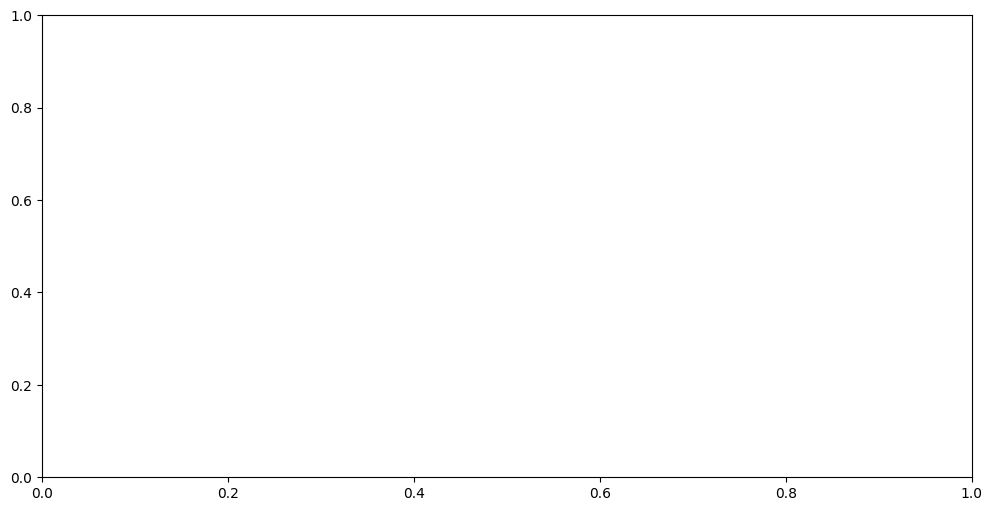

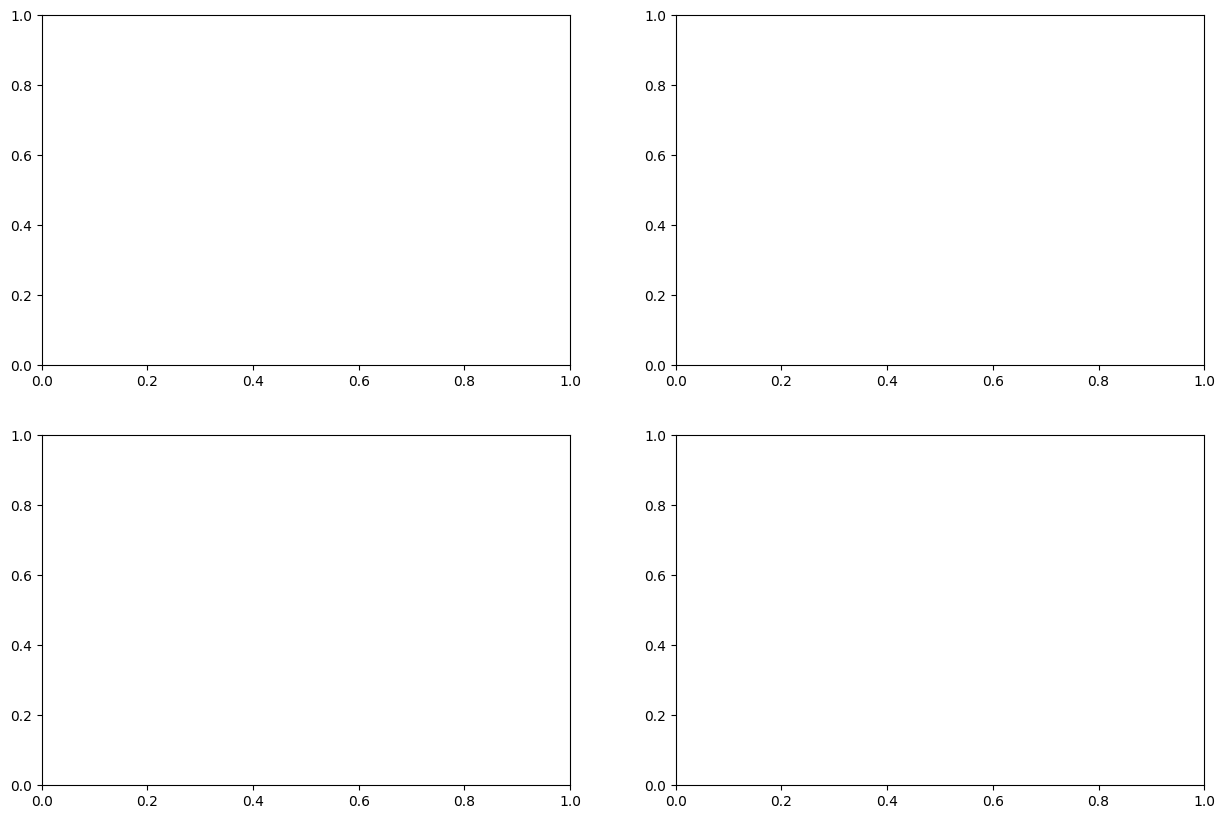

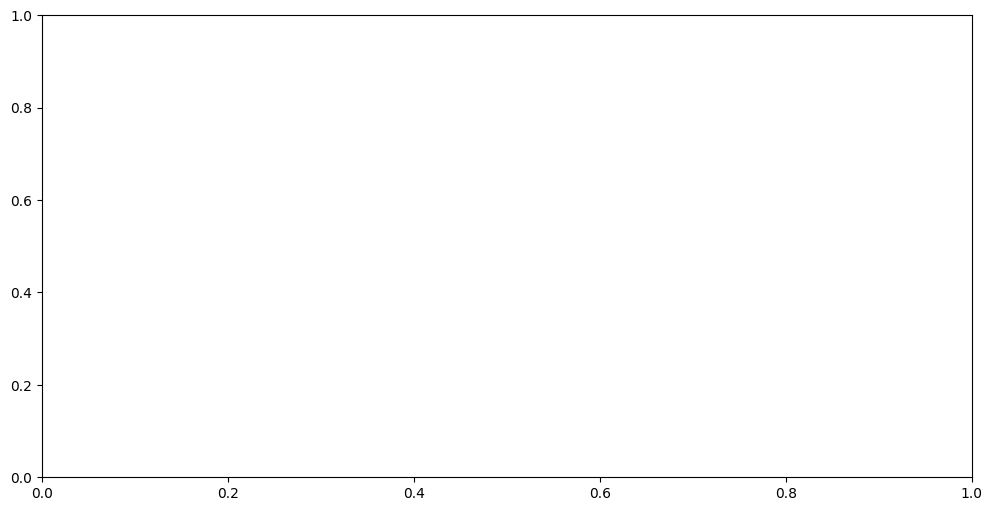

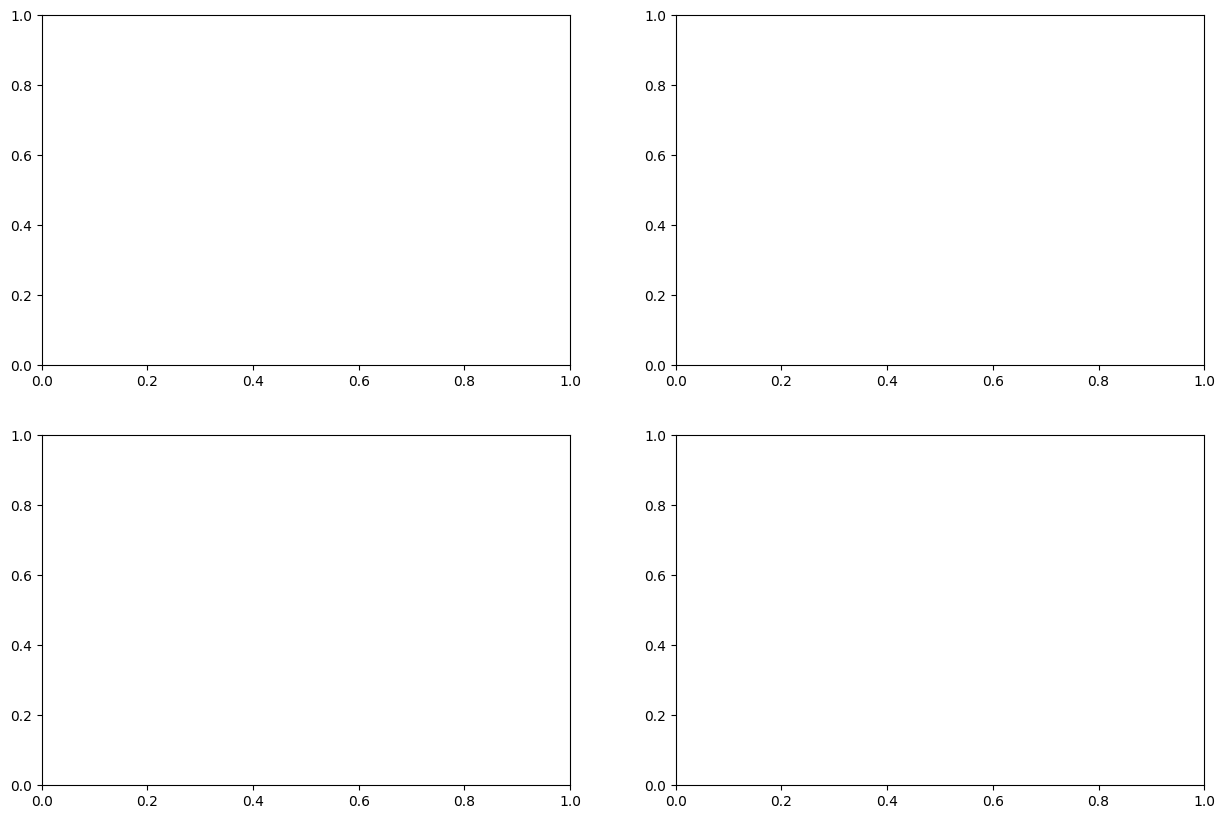

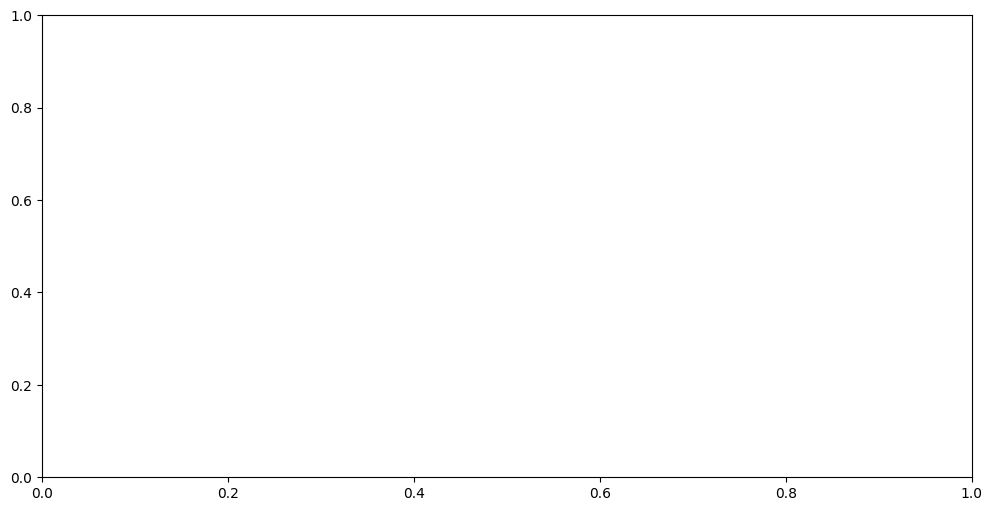

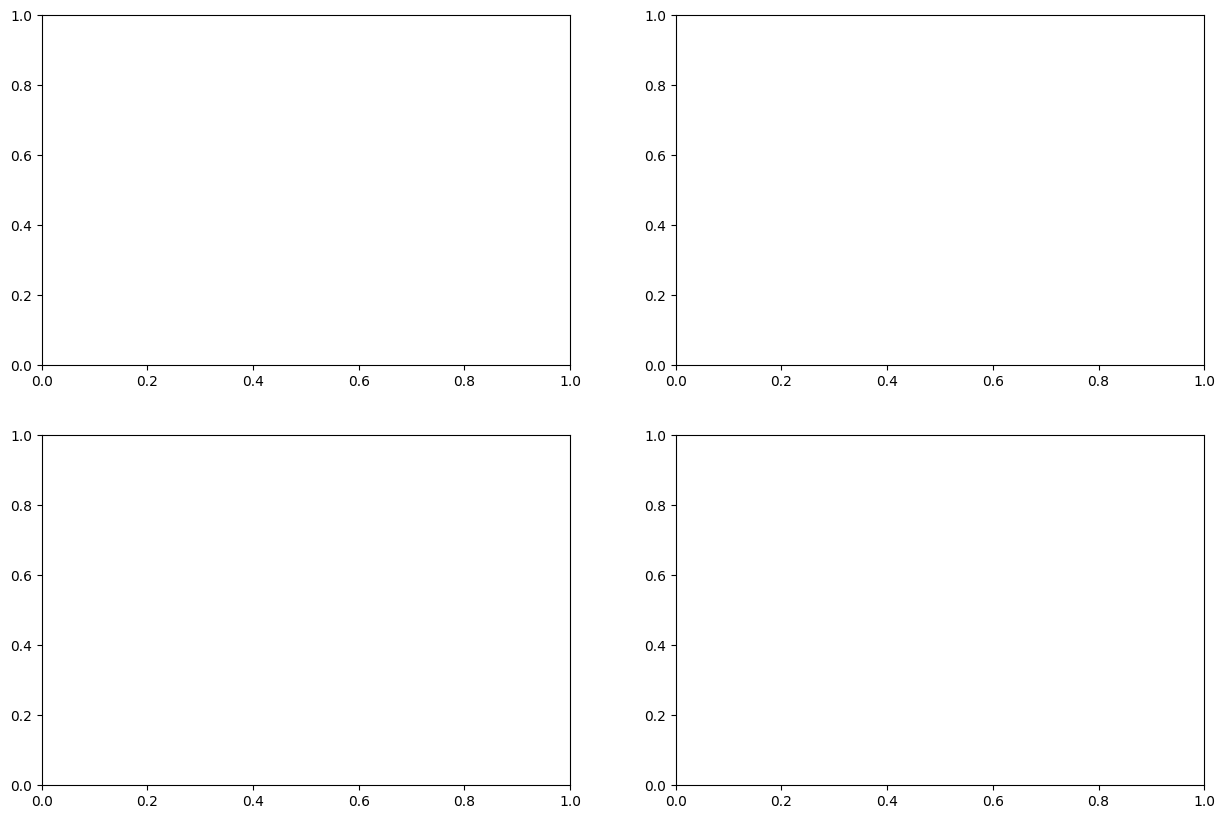

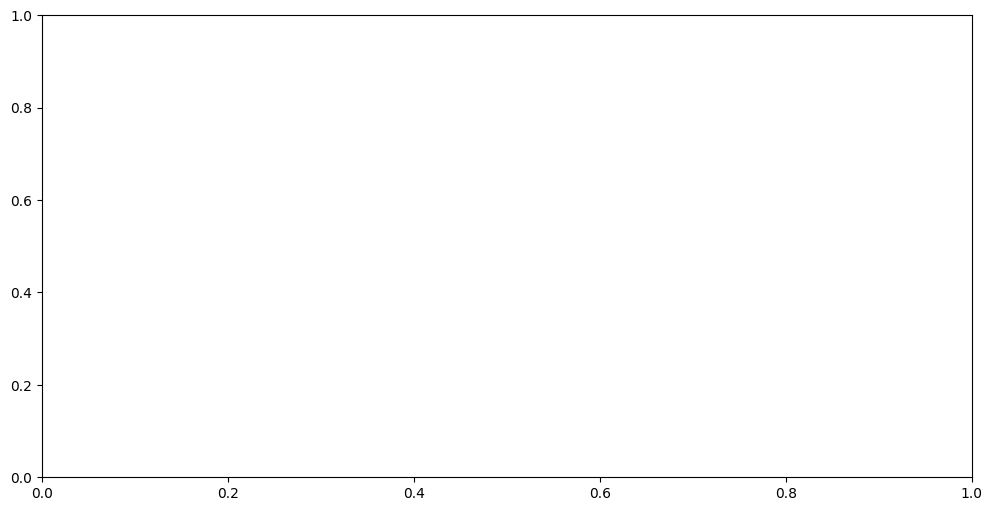

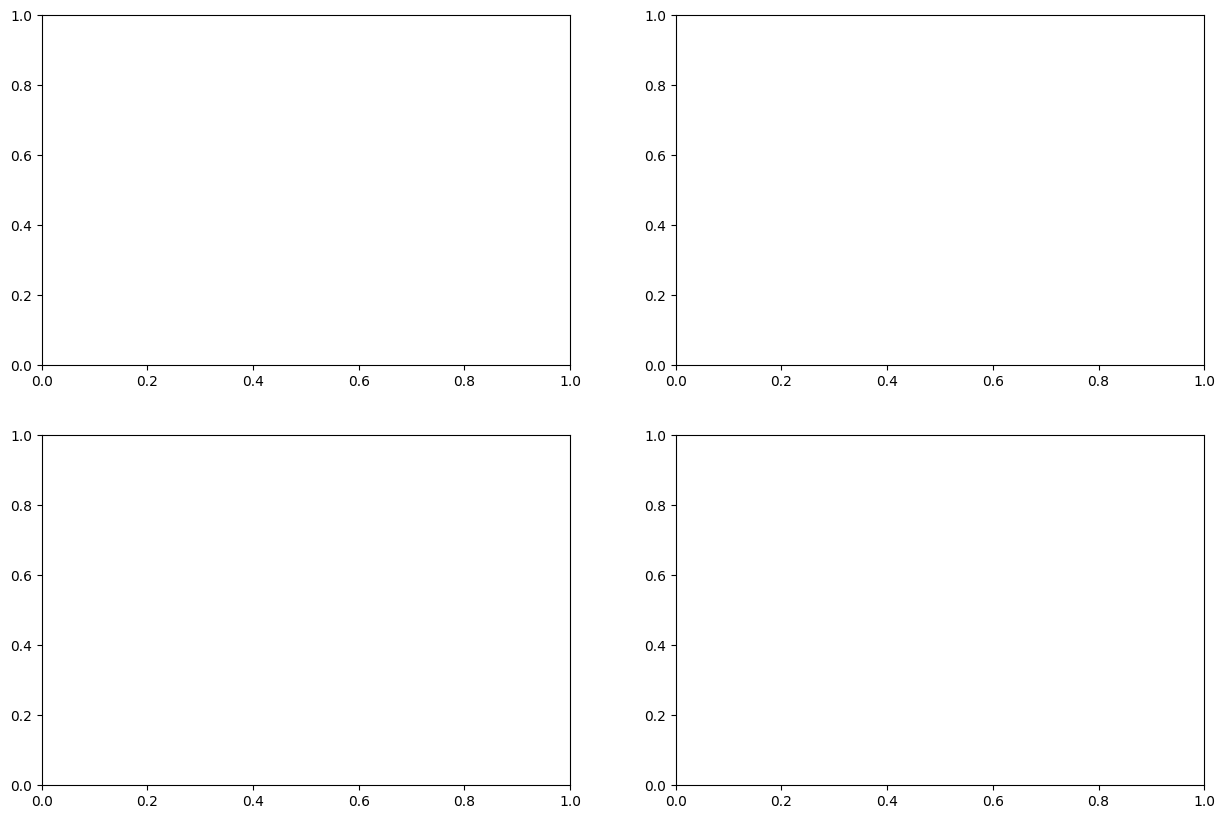

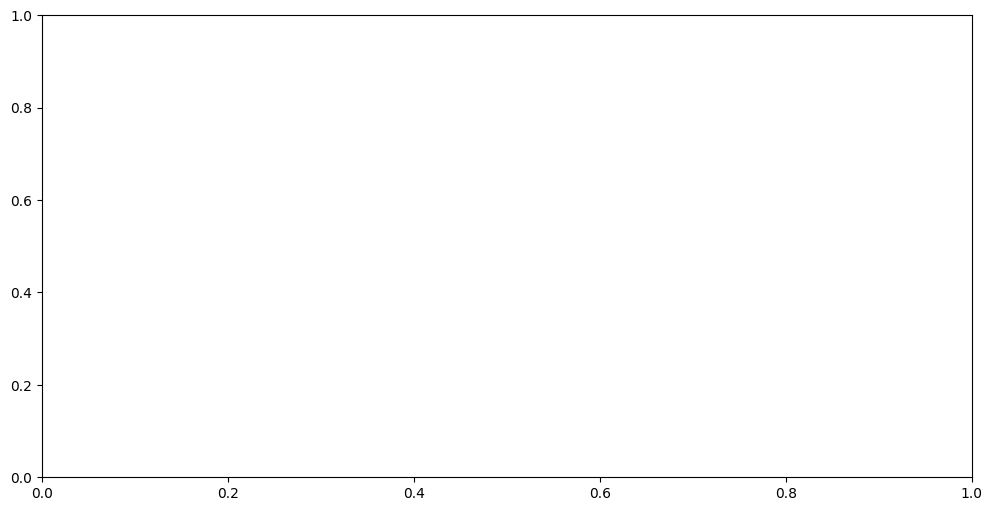

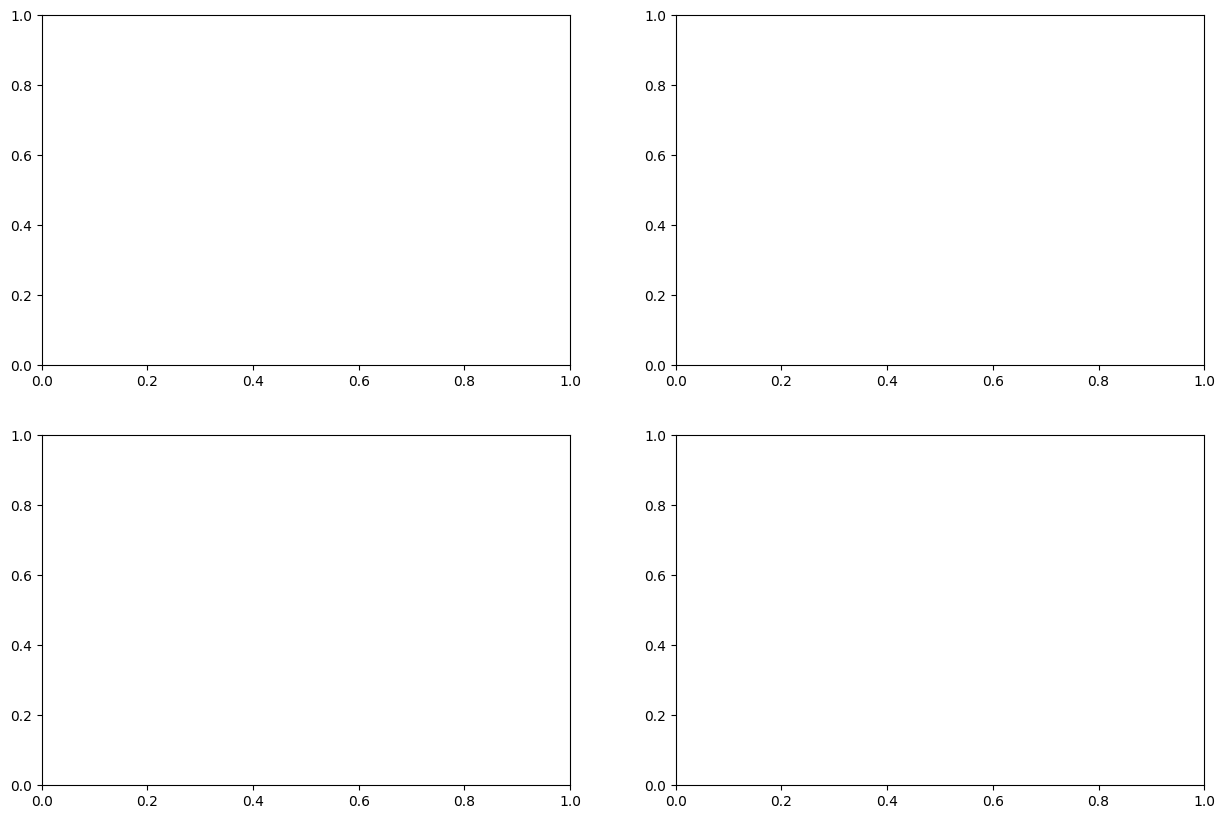

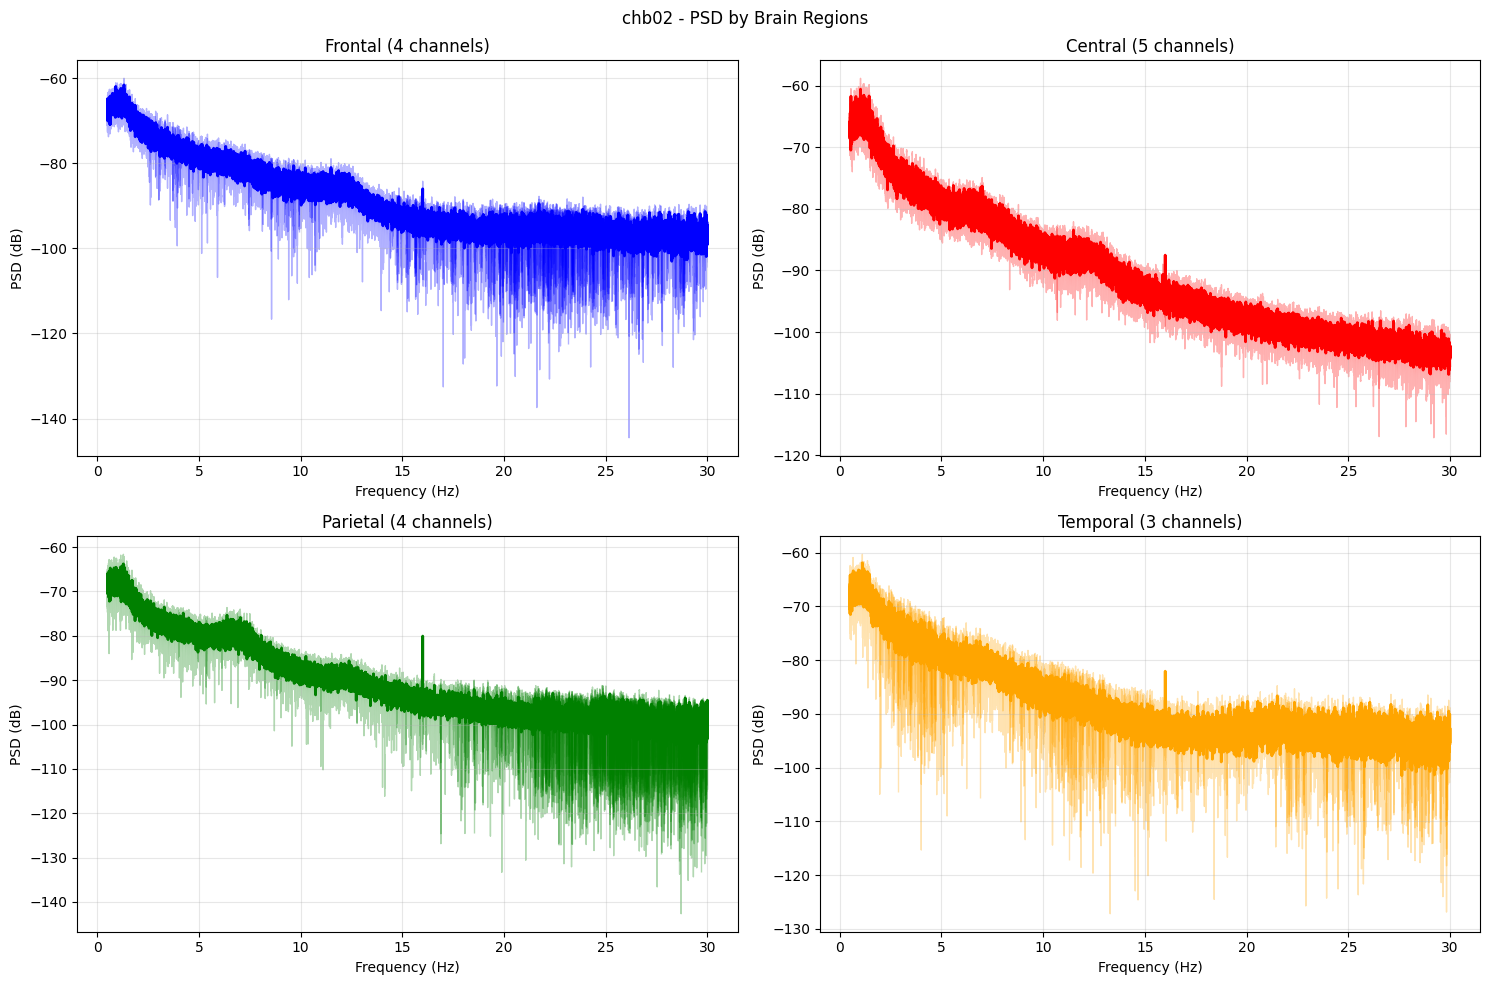

In [8]:
# Process Seina Scalp edf files
def process_all_chb_edf_files(data_dir='data/chb-mit', output_dir='plot_outputs'):
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Process subjects
    for subject_num in range(18):  # 1 to 24
        subject = f'chb{subject_num:02d}'  # Format as PN00, PN01, etc.
        subject_dir = Path(data_dir) / subject
        
        # Check if subject directory exists
        if not subject_dir.exists():
            print(f"Directory {subject_dir} not found, skipping...")
            continue
        
        # Find all .edf files in the subject directory
        edf_files = list(subject_dir.glob('*.edf'))
        
        if not edf_files:
            print(f"No EDF files found in {subject_dir}, skipping...")
            continue
        
        print(f"\nProcessing subject {subject}...")
        print(f"Found {len(edf_files)} EDF file(s)")
        
        # Process each EDF file
        for edf_file in edf_files:
            try:
                # Extract file number from filename (e.g., PN00-1.edf -> 1)
                file_stem = edf_file.stem  # Gets filename without extension
                file_num = file_stem.split('_')[-1] if '_' in file_stem else '1'
                
                print(f"  Processing {edf_file.name}...")
                
                # Load EDF file
                raw = mne.io.read_raw_edf(str(edf_file), preload=True, verbose=False)
                
                # Get available channels
                available_channels = raw.ch_names
                
                print(f"    Successfully loaded {len(available_channels)} channels")
                
                # Apply bandpass filter between 0.5 and 30 Hz
                raw.filter(0.5, 30, fir_design='firwin')
                
                # Plot the raw time series data
                fig = raw.plot(show=False)  # Set show=False to prevent display
                output_filename = output_path / f'{subject}_raw_{file_num}_edf_plot.png'
                fig.savefig(output_filename)
                plt.close(fig)
                print(f"    Saved raw plot to {output_filename}")
                
                # Plot Power Spectral Density (PSD)
                try:
                    fig_psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30).plot(
                        average=False,  # Show individual channels
                        amplitude=True,  # Show in dB
                        spatial_colors=True,  # Color by sensor location
                        show=False
                    )
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_plot.png'
                    fig_psd.savefig(psd_filename)
                    plt.close(fig_psd)
                    print(f"    Saved PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                
                try:
                    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
                    # Compute PSD
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    
                    # Get data and average across channels
                    psds, freqs = psd.get_data(return_freqs=True)
                    psd_mean = np.mean(psds, axis=0)
                    psd_std = np.std(psds, axis=0)
                    
                    # Plot mean with std as shaded area
                    ax.plot(freqs, 10 * np.log10(psd_mean), 'b-', linewidth=2, label='Mean PSD')
                    ax.fill_between(freqs, 
                                10 * np.log10(psd_mean - psd_std), 
                                10 * np.log10(psd_mean + psd_std), 
                                alpha=0.3, label='±1 SD')
                    
                    # Add frequency band annotations
                    ax.axvspan(8, 12, alpha=0.2, color='green', label='Alpha (8-12 Hz)')
                    ax.axvspan(13, 30, alpha=0.2, color='orange', label='Beta (13-30 Hz)')
                    ax.axvspan(4, 7, alpha=0.2, color='blue', label='Theta (4-7 Hz)')
                    
                    ax.set_xlabel('Frequency (Hz)')
                    ax.set_ylabel('Power Spectral Density (dB)')
                    ax.set_title(f'{subject} - Average PSD Across All Channels')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_averaged.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved averaged PSD plot to {psd_filename}")
                except Exception as e:
                    print(f"    Warning: Could not create PSD plot: {str(e)}")
                    
                try:
                    # Define channel groups (adjust based on your montage)
                    channel_groups = {
                        'Frontal': ['FP1-F7', 'FP1-F3', 'FP2-F4', 'FP2-F8'],
                        'Central': ['F3-C3', 'C3-P3', 'F4-C4', 'C4-P4', 'FZ-CZ'],
                        'Parietal': ['P3-O1', 'P4-O2', 'P8-O2', 'P7-T7'],
                        'Temporal': ['F7-T7', 'F8-T8', 'T8-P8-0', 'TZ-FT9']
                    }
                    
                    # Get available channels
                    available_channels = raw.ch_names
                    
                    # Filter groups to only include available channels
                    filtered_groups = {}
                    for group, channels in channel_groups.items():
                        available_in_group = [ch for ch in channels if ch in available_channels]
                        if available_in_group:
                            filtered_groups[group] = available_in_group
                    
                    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                    axes = axes.flatten()
                    
                    psd = raw.compute_psd(method='multitaper', fmin=0.5, fmax=30, verbose=False)
                    psds, freqs = psd.get_data(return_freqs=True)
                    
                    colors = ['blue', 'red', 'green', 'orange', 'purple']
                    
                    for idx, (group_name, channels) in enumerate(filtered_groups.items()):
                        if idx >= len(axes):
                            break
                            
                        ax = axes[idx]
                        
                        # Get indices for this group
                        ch_indices = [raw.ch_names.index(ch) for ch in channels if ch in raw.ch_names]
                        
                        if ch_indices:
                            # Average PSD for this group
                            group_psd = np.mean(psds[ch_indices, :], axis=0)
                            group_std = np.std(psds[ch_indices, :], axis=0)
                            
                            ax.plot(freqs, 10 * np.log10(group_psd), 
                                color=colors[idx % len(colors)], linewidth=2)
                            ax.fill_between(freqs, 
                                        10 * np.log10(group_psd - group_std), 
                                        10 * np.log10(group_psd + group_std), 
                                        alpha=0.3, color=colors[idx % len(colors)])
                            
                            ax.set_title(f'{group_name} ({len(channels)} channels)')
                            ax.set_xlabel('Frequency (Hz)')
                            ax.set_ylabel('PSD (dB)')
                            ax.grid(True, alpha=0.3)
                    
                    # Remove empty subplots
                    for idx in range(len(filtered_groups), len(axes)):
                        fig.delaxes(axes[idx])
                    
                    plt.suptitle(f'{subject} - PSD by Brain Regions')
                    plt.tight_layout()
                    
                    psd_filename = output_path / f'{subject}_raw_{file_num}_psd_by_regions.png'
                    plt.savefig(psd_filename, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"    Saved regional PSD plot to {psd_filename}")
                    
                except Exception as e:
                    print(f"    Warning: Could not create regional PSD plot: {str(e)}")
                
                
            except Exception as e:
                print(f"    Error processing {edf_file.name}: {str(e)}")
                continue
    
    print(f"\nProcessing complete! All plots saved to {output_dir}/")

# Run the function
process_all_chb_edf_files()

# Calculate Propagation Speed

In [ ]:
def detect_channel_onsets(data, sfreq, threshold, window_size, 
                         seizure_start=None, seizure_end=None):
    n_channels, n_samples = data.shape
    window_samples = int(window_size * sfreq)
    onset_times = {}
    
    for ch_idx in range(n_channels):
        channel_data = data[ch_idx, :]
        
        # Calculate envelope using Hilbert transform
        analytic_signal = signal.hilbert(channel_data)
        envelope = np.abs(analytic_signal)
        
        # Smooth envelope
        envelope_smooth = signal.savgol_filter(envelope, window_samples, 3)
        
        # Calculate baseline and threshold
        if seizure_start is not None and seizure_start > 10:
            # Use pre-seizure period as baseline
            baseline_end = int((seizure_start - 1) * sfreq)
            baseline = envelope_smooth[:baseline_end]
        else:
            # Use first 10 seconds as baseline
            baseline = envelope_smooth[:int(10 * sfreq)]
        
        baseline_mean = np.mean(baseline)
        baseline_std = np.std(baseline)
        onset_threshold = baseline_mean + threshold * baseline_std
        
        # Find onset (first crossing of threshold)
        if seizure_start is not None:
            # Search around known seizure time
            search_start = max(0, int((seizure_start - 5) * sfreq))
            search_end = min(n_samples, int((seizure_start + 10) * sfreq))
            search_region = envelope_smooth[search_start:search_end]
            
            crossings = np.where(search_region > onset_threshold)[0]
            if len(crossings) > 0:
                onset_sample = search_start + crossings[0]
                onset_times[ch_idx] = onset_sample / sfreq
        else:
            # Search entire signal
            crossings = np.where(envelope_smooth > onset_threshold)[0]
            if len(crossings) > 0:
                # Find sustained elevation (not just spikes)
                for crossing in crossings:
                    if crossing + window_samples < n_samples:
                        if np.mean(envelope_smooth[crossing:crossing+window_samples]) > onset_threshold:
                            onset_times[ch_idx] = crossing / sfreq
                            break
    
    return onset_times


def calculate_propagation_metrics(onset_times, ch_names, info):
    speeds = []
    delays = []
    sequence = []
    
    # Sort channels by onset time
    sorted_onsets = sorted(onset_times.items(), key=lambda x: x[1])
    
    # Get electrode positions (simplified - using standard positions)
    positions = estimate_electrode_positions(ch_names, info)
    
    # Calculate propagation between consecutive onsets
    for i in range(len(sorted_onsets) - 1):
        ch1_idx, time1 = sorted_onsets[i]
        ch2_idx, time2 = sorted_onsets[i + 1]
        
        # Time delay
        delay = time2 - time1
        delays.append(delay)
        
        # Spatial distance (in mm, estimated)
        if ch1_idx in positions and ch2_idx in positions:
            pos1 = positions[ch1_idx]
            pos2 = positions[ch2_idx]
            distance = euclidean(pos1, pos2) * 100  # Convert to mm
            
            # Calculate speed (mm/s)
            if delay > 0:
                speed = distance / delay
                speeds.append(speed)
        
        sequence.append((ch_names[ch1_idx], ch_names[ch2_idx], delay))
    
    return speeds, delays, sequence


def estimate_electrode_positions(ch_names, info):
    # Standard 10-20 system approximate positions (normalized)
    standard_positions = {
        'Fp1': (-0.3, 0.9), 'Fp2': (0.3, 0.9),
        'F3': (-0.5, 0.6), 'F4': (0.5, 0.6),
        'F7': (-0.8, 0.5), 'F8': (0.8, 0.5),
        'C3': (-0.5, 0), 'C4': (0.5, 0),
        'T3': (-0.9, 0), 'T4': (0.9, 0),
        'T5': (-0.8, -0.5), 'T6': (0.8, -0.5),
        'P3': (-0.5, -0.6), 'P4': (0.5, -0.6),
        'O1': (-0.3, -0.9), 'O2': (0.3, -0.9),
        'Fz': (0, 0.7), 'Cz': (0, 0), 'Pz': (0, -0.7)
    }
    
    positions = {}
    for idx, ch_name in enumerate(ch_names):
        # Try to match standard names
        ch_clean = ch_name.upper().replace('-', '').replace('EEG', '').strip()
        
        for std_name, pos in standard_positions.items():
            if std_name in ch_clean:
                positions[idx] = pos
                break
        
        # If no match, assign a default position
        if idx not in positions:
            # Distribute unknown channels in a circle
            angle = 2 * np.pi * idx / len(ch_names)
            positions[idx] = (np.cos(angle), np.sin(angle))
    
    return positions


def calculate_spatial_gradient(onset_times, ch_names):
    if len(onset_times) < 3:
        return None
    
    # Convert to arrays for analysis
    times = np.array(list(onset_times.values()))
    
    # Calculate gradient magnitude
    gradient = np.gradient(times)
    
    return {
        'mean_gradient': np.mean(np.abs(gradient)),
        'max_gradient': np.max(np.abs(gradient)),
        'gradient_variance': np.var(gradient)
    }


def classify_propagation_pattern(speeds, sequence):
    if not speeds:
        return 'No propagation detected'
    
    mean_speed = np.mean(speeds)
    std_speed = np.std(speeds)
    cv = std_speed / mean_speed if mean_speed > 0 else 0
    
    # Classification based on speed characteristics
    if mean_speed < 10:  # mm/s
        pattern = 'Slow propagation'
    elif mean_speed < 50:
        pattern = 'Moderate propagation'
    else:
        pattern = 'Fast propagation'
    
    # Add variability assessment
    if cv < 0.3:
        pattern += ' - Uniform'
    elif cv < 0.6:
        pattern += ' - Variable'
    else:
        pattern += ' - Highly variable'
    
    return pattern

In [ ]:
def extract_seizure_propagation_speeds(edf_path, 
                                      seizure_start_time=None, 
                                      seizure_end_time=None,
                                      sampling_rate=256,
                                      detection_threshold=3.0,
                                      window_size=1.0,
                                      min_seizure_duration=10):
    # Load EDF file
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    except Exception as e:
        print(f"Error loading EDF file: {e}")
        return None
    
    # Get data and channel info
    data = raw.get_data()
    ch_names = raw.ch_names
    sfreq = raw.info['sfreq']
    
    # Apply basic preprocessing
    # Bandpass filter for seizure frequencies (typically 3-30 Hz)
    data_filtered = mne.filter.filter_data(data, sfreq, l_freq=3, h_freq=30)
    
    # Initialize results dictionary
    results = {
        'file_path': edf_path,
        'num_channels': len(ch_names),
        'sampling_rate': sfreq,
        'propagation_speeds': [],
        'onset_delays': [],
        'onset_sequence': [],
        'mean_propagation_speed': None,
        'max_propagation_speed': None,
        'seizure_detected': False
    }
    
    # Detect seizure onset for each channel
    onset_times = detect_channel_onsets(data_filtered, sfreq, 
                                       detection_threshold, 
                                       window_size,
                                       seizure_start_time,
                                       seizure_end_time)
    
    if len(onset_times) < 2:
        print("Insufficient seizure onsets detected across channels")
        return results
    
    results['seizure_detected'] = True
    
    # Calculate propagation speeds
    speeds, delays, sequence = calculate_propagation_metrics(
        onset_times, ch_names, raw.info
    )
    
    results['propagation_speeds'] = speeds
    results['onset_delays'] = delays
    results['onset_sequence'] = sequence
    
    if speeds:
        results['mean_propagation_speed'] = np.mean(speeds)
        results['max_propagation_speed'] = np.max(speeds)
        results['median_propagation_speed'] = np.median(speeds)
        results['std_propagation_speed'] = np.std(speeds)
    
    # Add additional metrics
    results['spatial_gradient'] = calculate_spatial_gradient(onset_times, ch_names)
    results['propagation_pattern'] = classify_propagation_pattern(speeds, sequence)
    
    return results

In [ ]:
def process_dataset(edf_files, annotation_files=None, output_path='propagation_speeds.csv'):
    all_results = []
    
    for i, edf_file in enumerate(edf_files):
        print(f"Processing file {i+1}/{len(edf_files)}: {edf_file}")
        
        # Get seizure annotations if available
        seizure_start = None
        seizure_end = None
        
        if annotation_files and edf_file in annotation_files:
            # Parse annotation file for seizure times
            # This would depend on your annotation format
            pass
        
        # Extract propagation speeds
        results = extract_seizure_propagation_speeds(
            edf_file, 
            seizure_start_time=seizure_start,
            seizure_end_time=seizure_end
        )
        
        if results and results['seizure_detected']:
            # Flatten results for DataFrame
            flat_results = {
                'file': edf_file,
                'mean_speed': results['mean_propagation_speed'],
                'max_speed': results['max_propagation_speed'],
                'median_speed': results.get('median_propagation_speed'),
                'std_speed': results.get('std_propagation_speed'),
                'num_channels': results['num_channels'],
                'propagation_pattern': results['propagation_pattern'],
                'num_propagation_events': len(results['propagation_speeds'])
            }
            
            # Add spatial gradient metrics if available
            if results['spatial_gradient']:
                flat_results.update({
                    'mean_gradient': results['spatial_gradient']['mean_gradient'],
                    'gradient_variance': results['spatial_gradient']['gradient_variance']
                })
            
            all_results.append(flat_results)
    
    # Create DataFrame
    df = pd.DataFrame(all_results)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"Dataset saved to {output_path}")
    
    # Print summary statistics
    print("\n=== Dataset Summary ===")
    print(f"Total files processed: {len(edf_files)}")
    print(f"Files with detected seizures: {len(df)}")
    print(f"\nPropagation Speed Statistics:")
    print(f"Mean speed across all seizures: {df['mean_speed'].mean():.2f} mm/s")
    print(f"Median speed across all seizures: {df['median_speed'].median():.2f} mm/s")
    print(f"Speed range: {df['mean_speed'].min():.2f} - {df['mean_speed'].max():.2f} mm/s")
    
    return df

In [ ]:
edf_path = "data/PN00/PN00-1.edf"
results = extract_seizure_propagation_speeds(edf_path)